# Tutorial-3: Integrating Your Own Pre-processed Data
In this tutorial, we demonstrate how to convert h5ad data to MIDAS format and subsequently train a model. For versatility, we initially process the data using the Scanpy package and save the processed counts into CSV files. Utilizing the 'GenDataFromPath' function, we can structure the data in MIDAS input format and then proceed to train the model.

The 'GenDataFromPath' function allows for a quick start with MIDAS using your own pre-processed data.

Note: For RNA and protein data, the input counts must be integers, indicating that no normalization has been applied. For ATAC data, the input peaks data (convertible from fragment data using tools like MACS2 or others) must also be integers. ATAC features should be named as "chr1-...", "chr2-...", etc.

In [1]:
import scvi
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
sc.set_figure_params(figsize=(4, 4))

Global seed set to 0
/root/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/root/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## Load data

In [2]:
adata = scvi.data.pbmcs_10x_cite_seq()

INFO     File data/pbmc_10k_protein_v3.h5ad already downloaded                                                     
INFO     File data/pbmc_5k_protein_v3.h5ad already downloaded                                                      


/root/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## Pre-processed
Here, we select highly variable genes using Scanpy.

In [3]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.obs_names_make_unique()

In [4]:
sc.pp.highly_variable_genes(adata)

## Save pre-processed data

For each batch, we separately save the data of each modality into a CSV file (cells * features), ensuring that cell names and feature names are included in every file.

In [5]:
batch = adata.obs["batch"].unique()
for i, b in enumerate(batch):
    a = adata[adata.obs["batch"]==b, adata.var["highly_variable"]] # only highly variable genes are used
    rna = a.layers["counts"]
    adt = a.obsm["protein_expression"]
    var = a.var_names
    obs = a.obs_names
    pd.DataFrame(rna, index=obs, columns=var).to_csv(f"./rna_{i}.csv") # raw counts are saved
    pd.DataFrame(adt, index=obs).to_csv(f"./adt_{i}.csv") # raw counts are saved

## Convert data format & Read data

In [6]:
from scmidas.datasets import GenDataFromPath, GetDataInfo
from scmidas.models import MIDAS

In [ ]:
# substitute these paths to your own paths
data_path = [
    {"rna": "rna_0.csv", 
     "adt": "adt_0.csv"},
    {"rna": "rna_1.csv", 
     "adt": "adt_1.csv"},
]

In [ ]:
save_dir = "./data/processed/pbmc"
remove_old = True
GenDataFromPath(data_path, save_dir, remove_old) # generate a directory
data = GetDataInfo(save_dir) # read data from the generated directory

Removing directory "./data/processed/pbmc"
Spliting rna matrix: 6855 cells, 1483 features
Spliting adt matrix: 6855 cells, 14 features
Spliting rna matrix: 3994 cells, 1483 features
Spliting adt matrix: 3994 cells, 14 features
2 subset(s) in this path {'rna': 1483, 'adt': 14}
  subset_0 :  6855 cells ; ['rna', 'adt']
  subset_1 :  3994 cells ; ['rna', 'adt']


## Training

In [9]:
task = "pbmc" 
model = MIDAS(data)
model.init_model()
model.train(n_epoch=200, save_path=f'./result/{task}/train/')

Parameter number: 3.394 M
Training ...


Loss: 910.5270: 100%|██████████| 200/200 [28:45<00:00,  8.63s/it] 


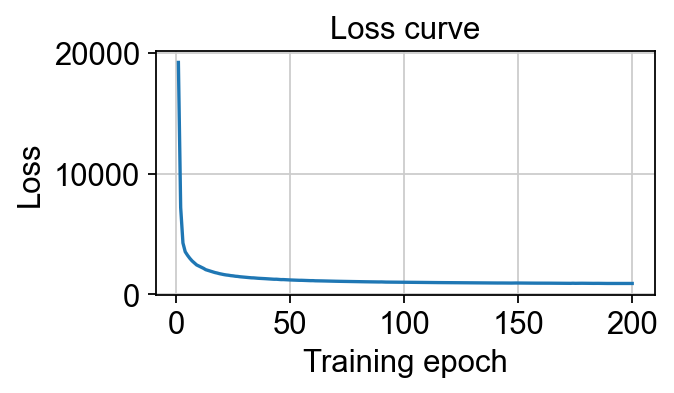

In [10]:
model.viz_loss() # to verify the convergence of the model

After training, you can refer to our Tutorial-1 and Tutorial-2 to obtain embeddings or other outputs for downstream analysis.

## Inference

In [11]:
model.predict(joint_latent=True, input=True, mod_latent=True, impute=True, batch_correct=True, remove_old=False)

  0%|          | 0/27 [00:00<?, ?it/s]

Predicting ...
Processing subset 0: ['rna', 'adt']


  0%|          | 0/16 [00:00<?, ?it/s]

Processing subset 1: ['rna', 'adt']


100%|██████████| 16/16 [00:00<00:00, 382.19it/s]


Calculating b_centroid ...
Loading predicted variables ...
Loading subset 0: z, joint
Loading subset 1: z, joint
Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: z, joint
Converting subset 1: s, joint
Converting subset 1: z, joint


  0%|          | 0/27 [00:00<?, ?it/s]

Batch correction ...
Processing subset 0: ['rna', 'adt']


  0%|          | 0/16 [00:00<?, ?it/s]

Processing subset 1: ['rna', 'adt']


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


## Visualization
In this section, we present the visualization of joint embeddings, modality-specific embeddings, and the batch-corrected counts for protein (ADT).

In [12]:
pred = model.read_preds(joint_latent=True, mod_latent=True, input=True, batch_correct=True, group_by="subset")

  0%|          | 0/27 [00:00<?, ?it/s]

Loading predicted variables ...
Loading subset 0: z, joint
Loading subset 0: z, rna
Loading subset 0: z, adt


  0%|          | 0/27 [00:00<?, ?it/s]

Loading subset 0: x_bc, rna


 30%|██▉       | 8/27 [00:00<00:00, 69.29it/s]

Loading subset 0: x_bc, adt
Loading subset 0: x, rna


  0%|          | 0/16 [00:00<?, ?it/s]

Loading subset 0: x, adt
Loading subset 1: z, joint
Loading subset 1: z, rna
Loading subset 1: z, adt


 50%|█████     | 8/16 [00:00<00:00, 71.84it/s]

Loading subset 1: x_bc, rna


 50%|█████     | 8/16 [00:00<00:00, 71.91it/s]

Loading subset 1: x_bc, adt
Loading subset 1: x, rna


100%|██████████| 16/16 [00:00<00:00, 1039.29it/s]


Loading subset 1: x, adt
Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: s, rna
Converting subset 0: s, adt
Converting subset 0: z, joint
Converting subset 0: z, rna
Converting subset 0: z, adt
Converting subset 0: x_bc, rna
Converting subset 0: x_bc, adt
Converting subset 0: x, rna
Converting subset 0: x, adt
Converting subset 1: s, joint
Converting subset 1: s, rna
Converting subset 1: s, adt
Converting subset 1: z, joint
Converting subset 1: z, rna
Converting subset 1: z, adt
Converting subset 1: x_bc, rna
Converting subset 1: x_bc, adt
Converting subset 1: x, rna
Converting subset 1: x, adt


In [15]:
import numpy as np

Visualize joint embeddings.

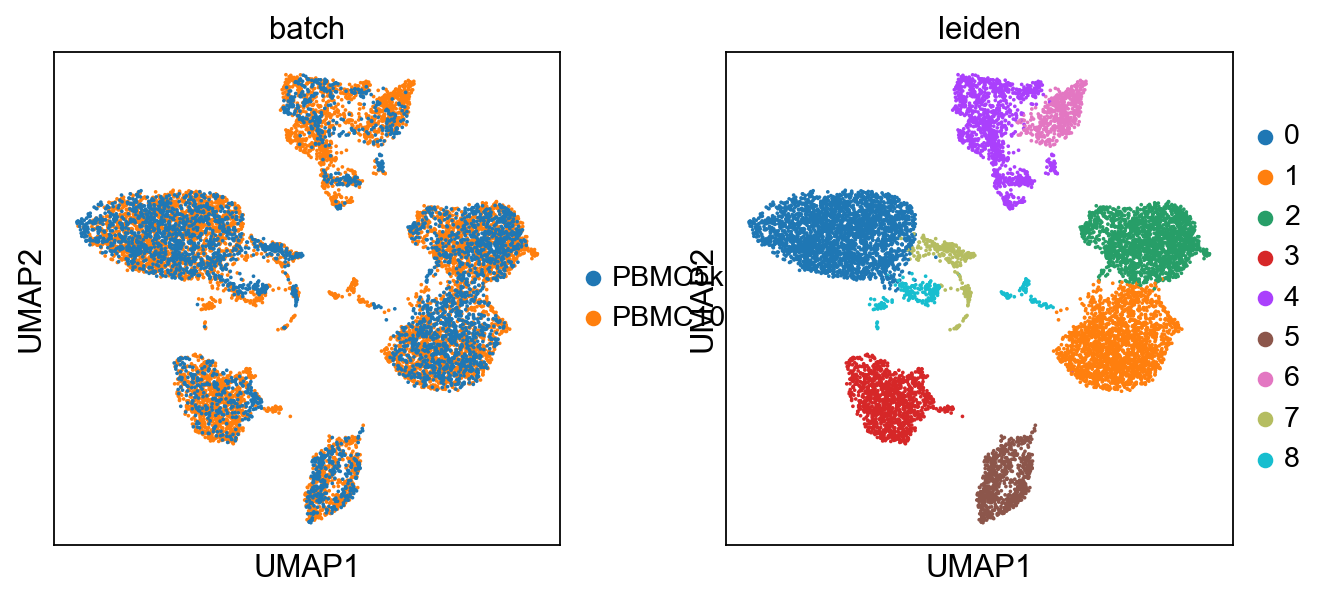

In [16]:
adata.obsm["emb"] = np.concatenate([pred[0]["z"]["joint"], pred[1]["z"]["joint"]])[:, :32]
sc.pp.neighbors(adata, use_rep="emb")
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden", resolution=0.3)
sc.pl.umap(adata, color=["batch", "leiden"])

Visualize modality embeddings.

In [17]:
adata_mod_latent = sc.concat({
    "rna":sc.AnnData(pred[0]["z"]["rna"]),
    "adt":sc.AnnData(pred[0]["z"]["adt"]),
    "rna":sc.AnnData(pred[1]["z"]["rna"]),
    "adt":sc.AnnData(pred[1]["z"]["adt"]),
}, label="modality")[:, :32]

/root/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/root/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


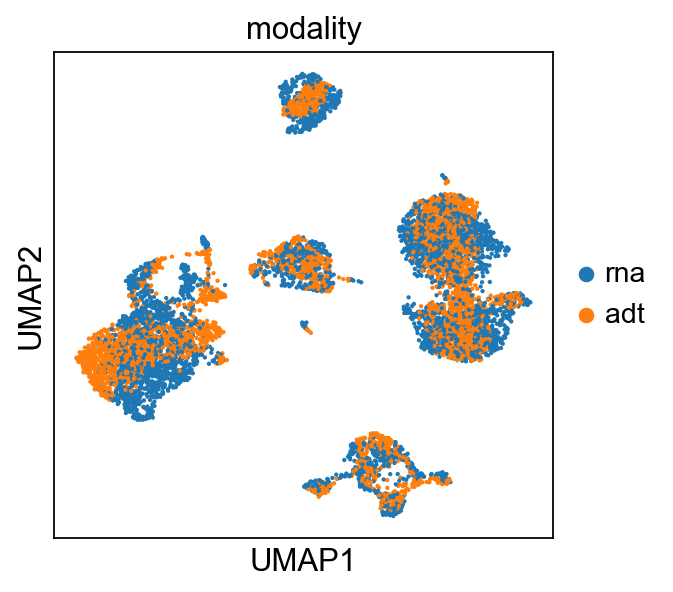

In [18]:
sc.pp.neighbors(adata_mod_latent)
sc.tl.umap(adata_mod_latent)
sc.pp.subsample(adata_mod_latent, fraction=1) # shuffle
sc.pl.umap(adata_mod_latent,color="modality")

Visualize batch-corrected protein counts. 

In [10]:
pred = model.read_preds("/opt/data/private/zjh/midasv2/result/experiment/predict", joint_latent=True, mod_latent=True, input=True, batch_correct=True, group_by="subset")

  0%|          | 0/27 [00:00<?, ?it/s]

Loading predicted variables ...
Loading subset 0: z, joint
Loading subset 0: z, rna


  0%|          | 0/27 [00:00<?, ?it/s]

Loading subset 0: z, adt
Loading subset 0: x_bc, rna


  0%|          | 0/27 [00:00<?, ?it/s]

Loading subset 0: x_bc, adt
Loading subset 0: x, rna


  0%|          | 0/16 [00:00<?, ?it/s]

Loading subset 0: x, adt
Loading subset 1: z, joint
Loading subset 1: z, rna
Loading subset 1: z, adt
Loading subset 1: x_bc, rna


100%|██████████| 16/16 [00:00<00:00, 66.78it/s]


Loading subset 1: x_bc, adt


 50%|█████     | 8/16 [00:00<00:00, 74.06it/s]

Loading subset 1: x, rna


100%|██████████| 16/16 [00:00<00:00, 281.14it/s]


Loading subset 1: x, adt
Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: s, rna
Converting subset 0: s, adt
Converting subset 0: z, joint
Converting subset 0: z, rna
Converting subset 0: z, adt
Converting subset 0: x_bc, rna
Converting subset 0: x_bc, adt
Converting subset 0: x, rna
Converting subset 0: x, adt
Converting subset 1: s, joint
Converting subset 1: s, rna
Converting subset 1: s, adt
Converting subset 1: z, joint
Converting subset 1: z, rna
Converting subset 1: z, adt
Converting subset 1: x_bc, rna
Converting subset 1: x_bc, adt
Converting subset 1: x, rna
Converting subset 1: x, adt


In [14]:
adata_x_bc = sc.concat([sc.AnnData(pred[0]["x_bc"]["adt"]), sc.AnnData(pred[1]["x_bc"]["adt"])])
adata_x_bc.var_names = model.reference_features["adt"]
adata_x_bc.obsm["emb"] = np.concatenate([pred[0]["z"]["joint"], pred[1]["z"]["joint"]])[:, :32]
sc.pp.neighbors(adata_x_bc, use_rep="emb")
sc.tl.umap(adata_x_bc)
sc.pp.log1p(adata_x_bc) # make the contrast more obvious, optional

/tmp/ipykernel_89140/765398715.py:1: FutureWarning: X.dtype being converted to np.float32 from int16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_x_bc = sc.concat([sc.AnnData(pred[0]["x_bc"]["adt"]), sc.AnnData(pred[1]["x_bc"]["adt"])])
/root/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
2024-07-01 01:54:45.857414: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


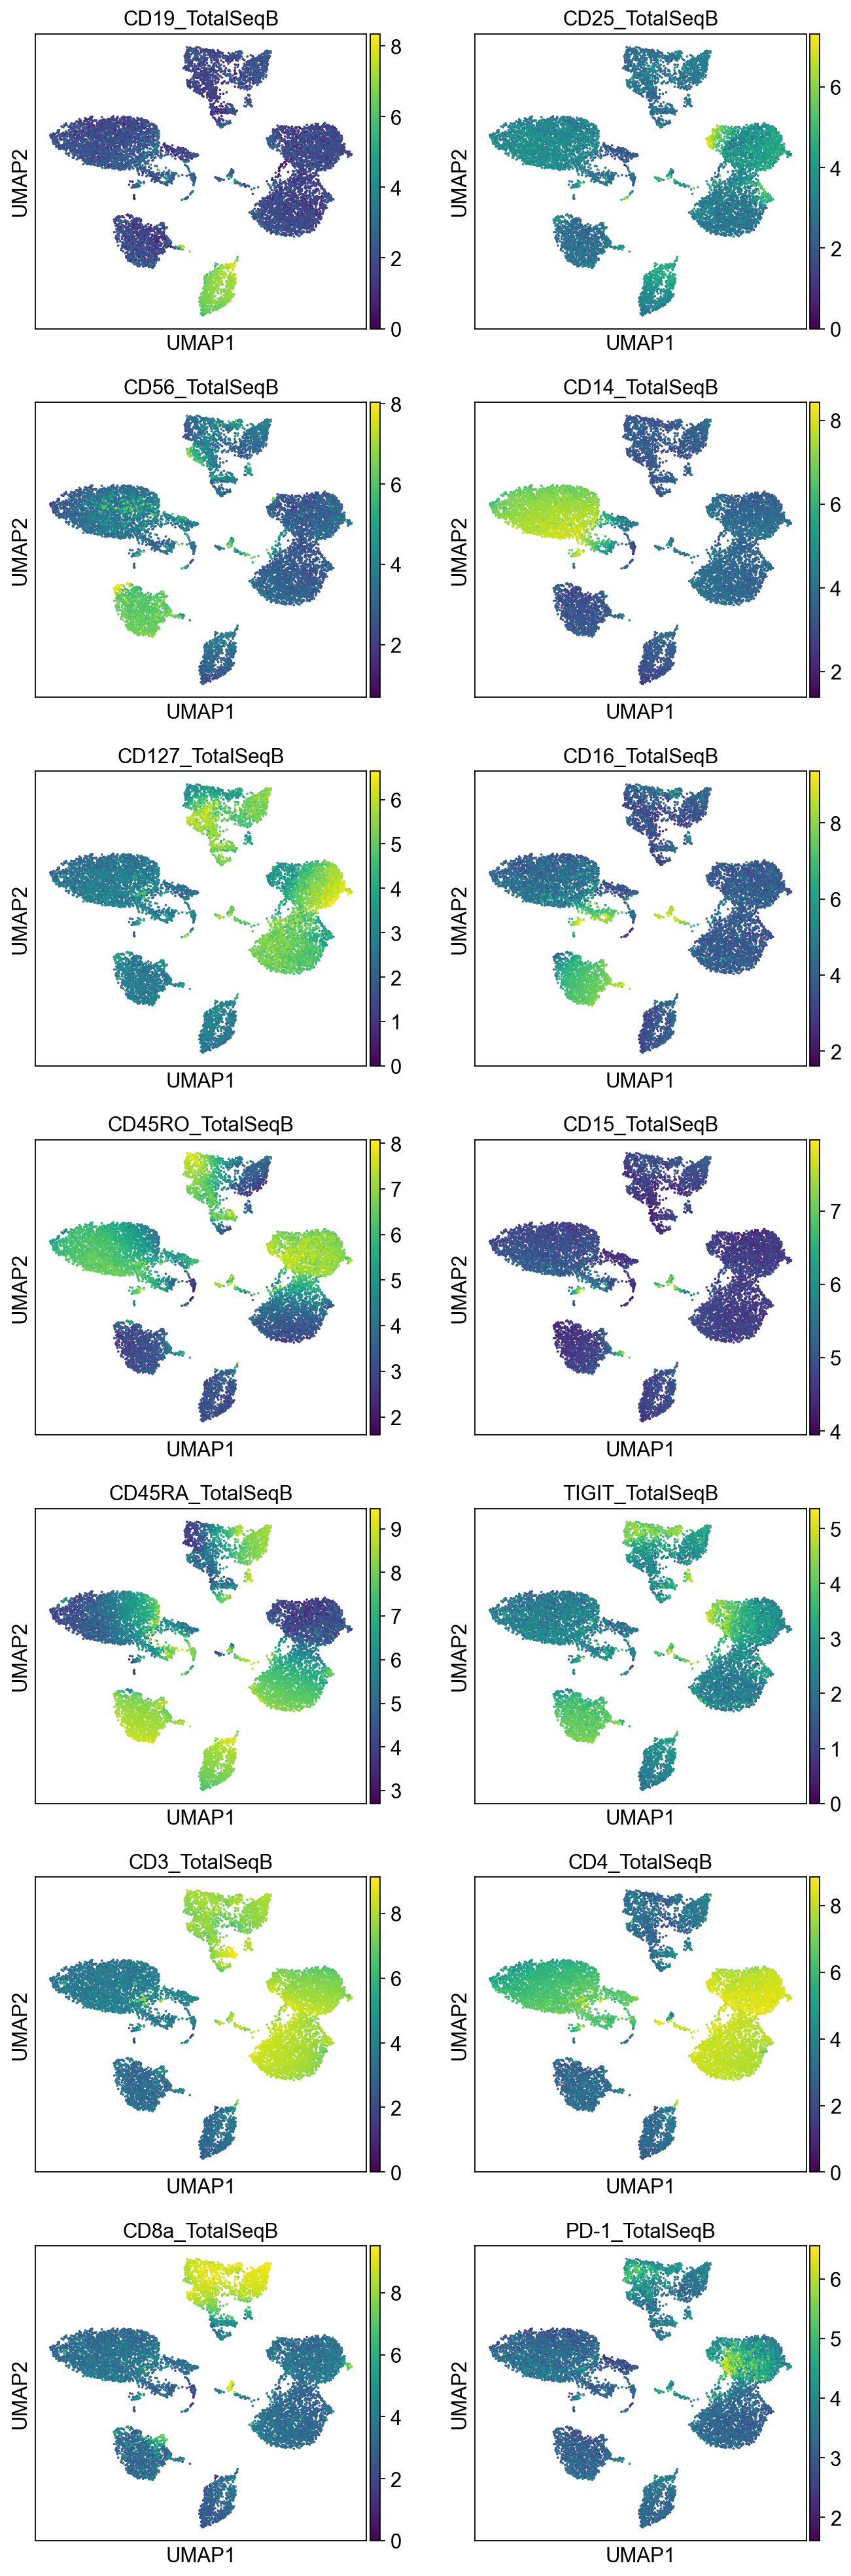

: 

In [17]:
sc.pl.umap(adata_x_bc, color=model.reference_features["adt"], ncols=2)